## Traffic Sign Classifier - GTSRB Dataset
### German Traffic Sign Recognition Benchmark (GTSRB)

This notebook implements a deep learning model to classify German traffic signs using the GTSRB dataset.
The dataset contains 43 classes of traffic signs with pre-split training and test sets.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report,
    balanced_accuracy_score,
    precision_recall_fscore_support
)

# Custom imports
from utils.gpu_utils import CheckGPU, CheckCUDA, CheckGPUBrief
from utils.gtsrb_dataset import (
    GTSRBDataset, 
    load_gtsrb_info, 
    print_gtsrb_summary,
    print_class_distribution_table
)

print("✅ All libraries and custom modules imported successfully!")

✅ All libraries and custom modules imported successfully!


#### Detect GPU Available, Details, Cuda, and cuDNN

In [2]:
# From utils.gpu_utils
CheckGPU()
CheckCUDA()

🖥️  GPU INFORMATION
✅ GPU Detected         : NVIDIA GeForce RTX 2060
   • Device ID          : 0
   • Compute Capability : 7.5
   • Multiprocessors    : 30
   • Total VRAM         : 6.00 GB
   • VRAM Allocated     : 0.00 GB
   • VRAM Reserved      : 0.00 GB
   • Active Device      : cuda

⚡ CUDA / PYTORCH INFORMATION
✅ CUDA Available       : True
   • PyTorch CUDA Ver.  : 12.4
   • PyTorch Version    : 2.6.0+cu124
✅ cuDNN Version        : 90100
   • CUDA Device Count  : 1
   • Device 0 Name     : NVIDIA GeForce RTX 2060


### Global Configuration Variables

In [3]:
# ============================
# GLOBAL CONFIGURATION
# ============================

# Dataset paths
DATASET_DIR = "../dataset"
TRAIN_CSV = os.path.join(DATASET_DIR, "Train.csv")
TEST_CSV = os.path.join(DATASET_DIR, "Test.csv")
META_CSV = os.path.join(DATASET_DIR, "Meta.csv")

# GTSRB has pre-split train/test, we'll create validation from training set
VALIDATION_SPLIT = 0.10  # 10% of training data for validation (90% train, 10% val)

# ROI (Region of Interest) Cropping
USE_ROI_CROP = True  # Crop images to sign bounding box before processing

# Augmentation settings
USE_AUGMENTATION = True

# Weighted sampling for class imbalance
USE_WEIGHTED_SAMPLER = True

# Normalization values
# Option 1: Use ImageNet pretrained values (recommended for transfer learning)
USE_IMAGENET_NORM = True
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Option 2: Compute from GTSRB dataset (set USE_IMAGENET_NORM = False to use these)
GTSRB_MEAN = [0.3403, 0.3121, 0.3214]  # Will be computed if needed
GTSRB_STD = [0.2724, 0.2608, 0.2669]   # Will be computed if needed

# Set normalization based on choice
if USE_IMAGENET_NORM:
    NORMALIZE_MEAN = IMAGENET_MEAN
    NORMALIZE_STD = IMAGENET_STD
    print("📊 Using ImageNet normalization values (recommended for transfer learning)")
else:
    NORMALIZE_MEAN = GTSRB_MEAN
    NORMALIZE_STD = GTSRB_STD
    print("📊 Using GTSRB-specific normalization values")

# Image settings
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Batch size & Classes
BATCH_SIZE = 48  # Increased for traffic signs (smaller images)
NUM_CLASSES = 43  # GTSRB has 43 traffic sign classes

# Model Architecture Selection
# Options: 'resnet50' or 'efficientnet_b3'
MODEL_ARCH = 'resnet50'  # Change this to 'efficientnet_b3' to switch models

# Model save path
MODEL_SAVE_DIR = "../models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Seed for reproducibility
SEED = 42

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f"✅ Global configuration set successfully!")
print(f"   Dataset: {DATASET_DIR}")
print(f"   Model Architecture: {MODEL_ARCH.upper()}")
print(f"   Classes: {NUM_CLASSES}")
print(f"   Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Validation Split: {VALIDATION_SPLIT*100:.0f}%")
print(f"   ROI Crop: {'ENABLED' if USE_ROI_CROP else 'DISABLED'}")
print(f"   Augmentation: {'ENABLED' if USE_AUGMENTATION else 'DISABLED'}")
print(f"   Weighted Sampler: {'ENABLED' if USE_WEIGHTED_SAMPLER else 'DISABLED'}")

📊 Using ImageNet normalization values (recommended for transfer learning)
✅ Global configuration set successfully!
   Dataset: ../dataset
   Model Architecture: RESNET50
   Classes: 43
   Image Size: 224x224
   Batch Size: 48
   Validation Split: 10%
   ROI Crop: ENABLED
   Augmentation: ENABLED
   Weighted Sampler: ENABLED


### GTSRB Dataset Analysis & Information

Load and analyze the GTSRB dataset structure, class distribution, and statistics.

In [4]:
# Load GTSRB dataset information
print("🔍 Loading GTSRB dataset information...")
dataset_info = load_gtsrb_info(DATASET_DIR)

# Print comprehensive summary
print_gtsrb_summary(dataset_info)

# Print detailed class distribution
print_class_distribution_table(dataset_info, top_n=10)

print("\n✅ Dataset information loaded successfully!")

🔍 Loading GTSRB dataset information...

🚦 GTSRB DATASET SUMMARY - German Traffic Sign Recognition Benchmark

📊 OVERALL STATISTICS
Total Classes:                 43
Training Samples:              39,209
Test Samples:                  12,630
Total Samples:                 51,839

🖼️  IMAGE SIZE STATISTICS (Original)
Average Size:                  50.8 x 50.3 pixels
Size Range (Width):            25 - 243 pixels
Size Range (Height):           25 - 225 pixels

🔷 SIGN SHAPE DISTRIBUTION
  Circular              15 classes ( 34.9%)
  Triangular            25 classes ( 58.1%)
  Octagonal              1 classes (  2.3%)
  Inverted Triangle      1 classes (  2.3%)
  Diamond                1 classes (  2.3%)

🎨 SIGN COLOR DISTRIBUTION
  Red Border            30 classes ( 69.8%)
  Blue                   8 classes ( 18.6%)
  Other                  1 classes (  2.3%)
  White/Blue             4 classes (  9.3%)

⚖️  CLASS BALANCE (Training Set)
Most populated class:          2,250 samples
Least popul

### Visualize Sample Images from Dataset

Display sample traffic signs from each class to understand the data better.

🖼️  Displaying sample traffic signs from dataset...


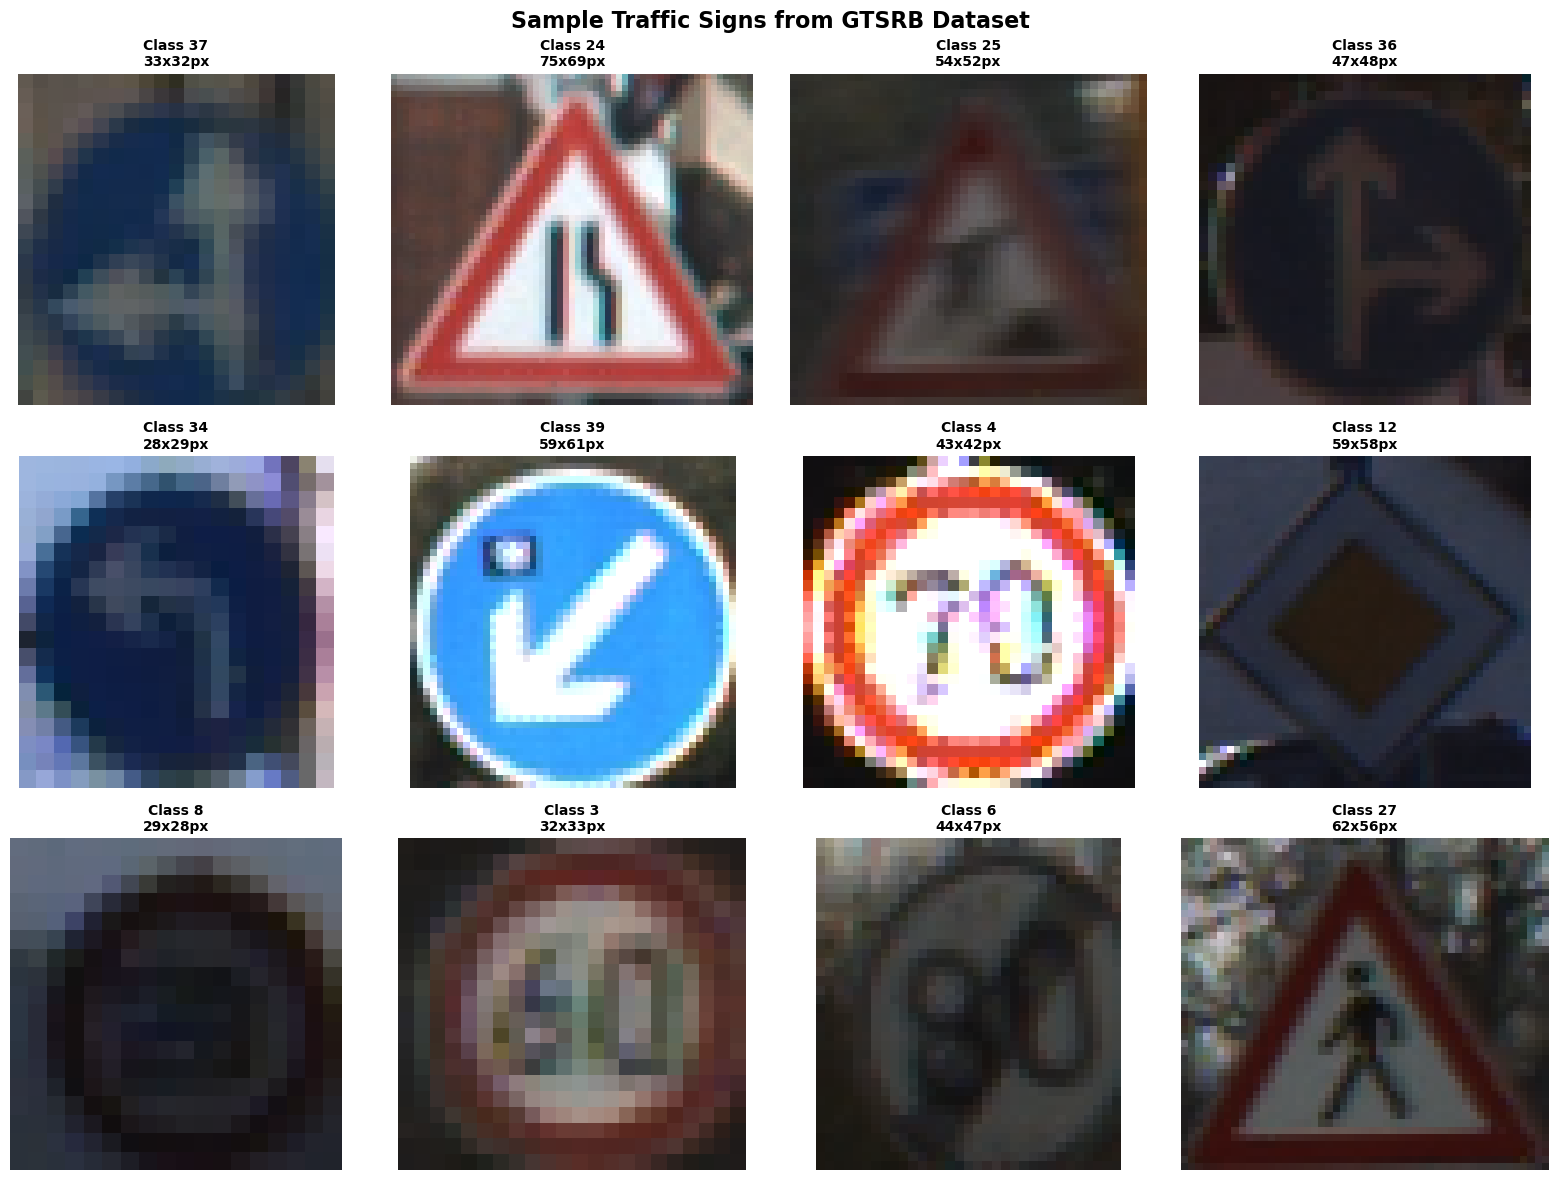

✅ Sample visualization complete!


In [5]:
# Visualize random samples from different classes
import matplotlib.pyplot as plt
from PIL import Image

print("🖼️  Displaying sample traffic signs from dataset...")

# Select 12 random classes to display
num_samples = 12
random_classes = np.random.choice(NUM_CLASSES, size=min(num_samples, NUM_CLASSES), replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

train_df = pd.read_csv(TRAIN_CSV)

for idx, class_id in enumerate(random_classes):
    # Get a random sample from this class
    class_samples = train_df[train_df['ClassId'] == class_id]
    sample_idx = np.random.choice(len(class_samples))
    sample_row = class_samples.iloc[sample_idx]
    
    # Load and display image
    img_path = os.path.join(DATASET_DIR, sample_row['Path'])
    img = Image.open(img_path).convert('RGB')
    
    # Apply ROI crop if enabled
    if USE_ROI_CROP:
        roi_x1, roi_y1 = sample_row['Roi.X1'], sample_row['Roi.Y1']
        roi_x2, roi_y2 = sample_row['Roi.X2'], sample_row['Roi.Y2']
        img = img.crop((roi_x1, roi_y1, roi_x2, roi_y2))
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Class {class_id}\n{sample_row["Width"]}x{sample_row["Height"]}px', 
                        fontsize=10, fontweight='bold')

plt.suptitle('Sample Traffic Signs from GTSRB Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Sample visualization complete!")

### Data Augmentation & Transforms

Define transforms for training (with augmentation) and validation/test sets.
GTSRB-specific augmentations optimized for traffic sign recognition.

In [6]:
if USE_AUGMENTATION:
    # Training augmentation - optimized for traffic signs
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        # Geometric augmentations (moderate for traffic signs)
        transforms.RandomRotation(15),  # Signs can be at slight angles
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # Color augmentations (helps with lighting variations)
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        # Random perspective (simulates viewing angle)
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        # Convert to tensor
        transforms.ToTensor(),
        # Normalize
        transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD),
        # Random erasing (simulates occlusion/dirt)
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    print("✅ Training augmentation ENABLED")
    print("   - Rotation: ±15°")
    print("   - Translation: ±10%")
    print("   - Scale: 90-110%")
    print("   - Color jitter: brightness/contrast/saturation/hue")
    print("   - Perspective distortion")
    print("   - Random erasing (occlusion simulation)")
else:
    # No augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
    ])
    print("⚠️  Training augmentation DISABLED")

# Validation and test transforms (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

print(f"✅ Transforms defined successfully!")
print(f"   Target size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"   Normalization: Mean={NORMALIZE_MEAN}, Std={NORMALIZE_STD}")

✅ Training augmentation ENABLED
   - Rotation: ±15°
   - Translation: ±10%
   - Scale: 90-110%
   - Color jitter: brightness/contrast/saturation/hue
   - Perspective distortion
   - Random erasing (occlusion simulation)
✅ Transforms defined successfully!
   Target size: 224x224
   Normalization: Mean=[0.485, 0.456, 0.406], Std=[0.229, 0.224, 0.225]


### Load GTSRB Datasets

Load the pre-split training and test sets from CSV files.
Create validation set by splitting the training data.

In [7]:
# Load full training dataset (will split into train/val)
print("📂 Loading GTSRB training dataset...")
full_train_dataset = GTSRBDataset(
    csv_path=TRAIN_CSV,
    root_dir=DATASET_DIR,
    transform=None,  # Will assign transforms after split
    use_roi=USE_ROI_CROP
)

# Load test dataset
print("📂 Loading GTSRB test dataset...")
test_dataset = GTSRBDataset(
    csv_path=TEST_CSV,
    root_dir=DATASET_DIR,
    transform=val_test_transforms,  # No augmentation for test
    use_roi=USE_ROI_CROP
)

num_total_train = len(full_train_dataset)
num_test = len(test_dataset)

print(f"✅ Datasets loaded successfully!")
print(f"   Training samples (before split): {num_total_train:,}")
print(f"   Test samples: {num_test:,}")

# Split training into train and validation
val_size = int(VALIDATION_SPLIT * num_total_train)
train_size = num_total_train - val_size

# Use random_split to create train/val indices
train_subset, val_subset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\n✅ Training data split completed:")
print(f"   🔹 Train: {train_size:,} samples ({(1-VALIDATION_SPLIT)*100:.0f}%)")
print(f"   🔹 Validation: {val_size:,} samples ({VALIDATION_SPLIT*100:.0f}%)")
print(f"   🔹 Test: {num_test:,} samples (separate set)")

# Assign transforms to subsets
train_subset.dataset.transform = train_transforms
val_subset.dataset.transform = val_test_transforms

print(f"\n✅ Transforms assigned:")
print(f"   Train: Augmentation {'ENABLED' if USE_AUGMENTATION else 'DISABLED'}")
print(f"   Validation/Test: No augmentation")

📂 Loading GTSRB training dataset...
📂 Loading GTSRB test dataset...
✅ Datasets loaded successfully!
   Training samples (before split): 39,209
   Test samples: 12,630

✅ Training data split completed:
   🔹 Train: 35,289 samples (90%)
   🔹 Validation: 3,920 samples (10%)
   🔹 Test: 12,630 samples (separate set)

✅ Transforms assigned:
   Train: Augmentation ENABLED
   Validation/Test: No augmentation


### Compute Class Weights for Imbalanced Data

Calculate class weights to handle the imbalanced GTSRB dataset.
This helps the model learn minority classes better.

In [8]:
# Get class distribution from training data
train_df = pd.read_csv(TRAIN_CSV)
class_counts = train_df['ClassId'].value_counts().sort_index().values

print(f"📊 Class distribution in training set:")
print(f"   Total classes: {len(class_counts)}")
print(f"   Most populated class: {class_counts.max():,} samples")
print(f"   Least populated class: {class_counts.min():,} samples")
print(f"   Average per class: {class_counts.mean():.1f} samples")
print(f"   Imbalance ratio: {class_counts.max() / class_counts.min():.2f}x")

# Compute class weights (inverse frequency)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize

print(f"\n📐 Class weights computed:")
print(f"   Min weight: {class_weights.min():.4f}")
print(f"   Max weight: {class_weights.max():.4f}")
print(f"   Weight ratio: {class_weights.max() / class_weights.min():.2f}x")

# Create sample weights for WeightedRandomSampler
if USE_WEIGHTED_SAMPLER:
    # Get labels from training subset
    train_indices = train_subset.indices
    train_labels = [train_df.iloc[idx]['ClassId'] for idx in train_indices]
    sample_weights = [class_weights[label] for label in train_labels]
    
    print(f"\n✅ Weighted sampler initialized for {len(sample_weights):,} training samples")
else:
    sample_weights = None
    print("\n⚠️  Weighted sampler DISABLED")

📊 Class distribution in training set:
   Total classes: 43
   Most populated class: 2,250 samples
   Least populated class: 210 samples
   Average per class: 911.8 samples
   Imbalance ratio: 10.71x

📐 Class weights computed:
   Min weight: 0.2209
   Max weight: 2.3673
   Weight ratio: 10.71x

✅ Weighted sampler initialized for 35,289 training samples


### Create DataLoaders

Initialize PyTorch DataLoaders with appropriate batch size and sampling strategy.

In [9]:
# Create training DataLoader
if USE_WEIGHTED_SAMPLER:
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=0,  # Set to 0 for Windows compatibility
        pin_memory=True if torch.cuda.is_available() else False
    )
    print(f"✅ Train DataLoader: {len(train_subset):,} samples with WeightedRandomSampler")
else:
    train_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    print(f"✅ Train DataLoader: {len(train_subset):,} samples with shuffle=True")

# Create validation DataLoader
val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
print(f"✅ Validation DataLoader: {len(val_subset):,} samples")

# Create test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
print(f"✅ Test DataLoader: {len(test_dataset):,} samples")

print(f"\n📦 Batch configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

✅ Train DataLoader: 35,289 samples with WeightedRandomSampler
✅ Validation DataLoader: 3,920 samples
✅ Test DataLoader: 12,630 samples

📦 Batch configuration:
   Batch size: 48
   Train batches: 736
   Validation batches: 82
   Test batches: 264


#### PRINT SUMMARY

In [10]:
print("\n" + "="*80)
print("📊 PREPROCESSING SUMMARY")
print("="*80)
print(f"{'Dataset:':<30} GTSRB (German Traffic Signs)")
print(f"{'Total Classes:':<30} {NUM_CLASSES}")
print(f"{'Training Samples:':<30} {train_size:,}")
print(f"{'Validation Samples:':<30} {val_size:,}")
print(f"{'Test Samples:':<30} {num_test:,}")
print(f"{'Total Samples:':<30} {train_size + val_size + num_test:,}")
print(f"\n{'Image Processing:':<30}")
print(f"  {'- Target Size:':<28} {IMG_HEIGHT}x{IMG_WIDTH} pixels")
print(f"  {'- ROI Cropping:':<28} {'ENABLED' if USE_ROI_CROP else 'DISABLED'}")
print(f"  {'- Normalization:':<28} {'ImageNet' if USE_IMAGENET_NORM else 'GTSRB'}")
print(f"\n{'Augmentation:':<30} {'ENABLED' if USE_AUGMENTATION else 'DISABLED'}")
if USE_AUGMENTATION:
    print(f"  - Rotation, Translation, Scale, Color Jitter, Perspective, Erasing")
print(f"\n{'Class Balancing:':<30}")
print(f"  {'- Weighted Sampling:':<28} {'ENABLED' if USE_WEIGHTED_SAMPLER else 'DISABLED'}")
print(f"  {'- Class Imbalance Ratio:':<28} {class_counts.max() / class_counts.min():.2f}x")
print(f"\n{'Batch Configuration:':<30}")
print(f"  {'- Batch Size:':<28} {BATCH_SIZE}")
print(f"  {'- Train Batches/Epoch:':<28} {len(train_loader)}")
print(f"  {'- Val Batches/Epoch:':<28} {len(val_loader)}")
print(f"  {'- Test Batches:':<28} {len(test_loader)}")
print("="*80)
print("✅ Preprocessing complete! Ready for model training.\n")


📊 PREPROCESSING SUMMARY
Dataset:                       GTSRB (German Traffic Signs)
Total Classes:                 43
Training Samples:              35,289
Validation Samples:            3,920
Test Samples:                  12,630
Total Samples:                 51,839

Image Processing:             
  - Target Size:               224x224 pixels
  - ROI Cropping:              ENABLED
  - Normalization:             ImageNet

Augmentation:                  ENABLED
  - Rotation, Translation, Scale, Color Jitter, Perspective, Erasing

Class Balancing:              
  - Weighted Sampling:         ENABLED
  - Class Imbalance Ratio:     10.71x

Batch Configuration:          
  - Batch Size:                48
  - Train Batches/Epoch:       736
  - Val Batches/Epoch:         82
  - Test Batches:              264
✅ Preprocessing complete! Ready for model training.



#### MODEL TRAINING KEY VARIABLES

In [11]:
# ============================
# MODEL TRAINING CONFIGURATION
# ============================

# Training hyperparameters
LEARNING_RATE = 0.0001
MAX_EPOCHS = 30  # Maximum training epochs
WEIGHT_DECAY = 1e-4  # L2 regularization to prevent overfitting
DROPOUT_RATE = 0.4  # Dropout in classifier head

# Early stopping
EARLY_STOPPING_PATIENCE = 10  # Stop if no improvement for 10 epochs

# Gradient clipping
MAX_GRAD_NORM = 1.0  # Prevent exploding gradients

# Training history dictionary (global)
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_top5_acc": [],
    "val_top5_acc": [],
    "learning_rates": []
}

print("🎯 Training Configuration:")
print(f"   Model: {MODEL_ARCH.upper()}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Weight Decay: {WEIGHT_DECAY}")
print(f"   Dropout Rate: {DROPOUT_RATE}")
print(f"   Max Epochs: {MAX_EPOCHS}")
print(f"   Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print(f"   Classes: {NUM_CLASSES}")

🎯 Training Configuration:
   Model: RESNET50
   Learning Rate: 0.0001
   Weight Decay: 0.0001
   Dropout Rate: 0.4
   Max Epochs: 30
   Early Stopping Patience: 10
   Classes: 43


### Load Pretrained Model Architecture

In [12]:
# Load pretrained model based on MODEL_ARCH configuration
CheckCUDA()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_ARCH == 'resnet50':
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    print("\n✅ Pre-trained ResNet50 loaded (weights: IMAGENET1K_V1)")
    
    # Replace classifier head with dropout
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(in_features, NUM_CLASSES)
    )
    print(f"✅ Classifier replaced: {in_features} → Dropout({DROPOUT_RATE}) → {NUM_CLASSES} classes")

elif MODEL_ARCH == 'efficientnet_b3':
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
    print("✅ Pre-trained EfficientNet-B3 loaded (weights: IMAGENET1K_V1)")
    
    # Replace classifier head with dropout
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(DROPOUT_RATE, inplace=True),
        nn.Linear(in_features, NUM_CLASSES)
    )
    print(f"✅ Classifier replaced: {in_features} → Dropout({DROPOUT_RATE}) → {NUM_CLASSES} classes")

else:
    raise ValueError(f"Unknown model architecture: {MODEL_ARCH}. Choose 'resnet50' or 'efficientnet_b3'")

# Move model to GPU
model = model.to(device)
print(f"✅ Model moved to device: {device.type.upper()}")
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")


⚡ CUDA / PYTORCH INFORMATION
✅ CUDA Available       : True
   • PyTorch CUDA Ver.  : 12.4
   • PyTorch Version    : 2.6.0+cu124
✅ cuDNN Version        : 90100
   • CUDA Device Count  : 1
   • Device 0 Name     : NVIDIA GeForce RTX 2060

✅ Pre-trained ResNet50 loaded (weights: IMAGENET1K_V1)
✅ Classifier replaced: 2048 → Dropout(0.4) → 43 classes
✅ Model moved to device: CUDA
📊 Model parameters: 23,596,139


#### LOSS & OPTIMIZER

In [23]:
# Loss function with class weights
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f"✅ Loss function: CrossEntropyLoss with class weights")

# Adam optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
print(f"✅ Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")

# Learning rate scheduler - ReduceLROnPlateau (reduces LR when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3,
    min_lr=1e-7
)
print(f"✅ LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")


✅ Loss function: CrossEntropyLoss with class weights
✅ Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
✅ LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


#### Model Summary

In [14]:
print("\n" + "="*60)
print("🚀 MODEL SETUP COMPLETE")
print("="*60)
print(f"{'Architecture:':<25} {MODEL_ARCH.upper()}")
print(f"{'Input Size:':<25} {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"{'Output Classes:':<25} {NUM_CLASSES}")
print(f"{'Total Parameters:':<25} {sum(p.numel() for p in model.parameters()):,}")
print(f"{'Trainable Parameters:':<25} {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"\n{'Training Settings:':<25}")
print(f"{'  Learning Rate:':<25} {LEARNING_RATE}")
print(f"{'  Weight Decay:':<25} {WEIGHT_DECAY}")
print(f"{'  Dropout Rate:':<25} {DROPOUT_RATE}")
print(f"{'  Max Epochs:':<25} {MAX_EPOCHS}")
print(f"{'  Early Stop Patience:':<25} {EARLY_STOPPING_PATIENCE}")
print(f"{'  Device:':<25} {device.type.upper()}")
print(f"{'  Loss Function:':<25} CrossEntropyLoss (weighted)")
print(f"{'  Optimizer:':<25} AdamW")
print(f"{'  LR Scheduler:':<25} ReduceLROnPlateau")
print("="*60 + "\n")



🚀 MODEL SETUP COMPLETE
Architecture:             RESNET50
Input Size:               224x224
Output Classes:           43
Total Parameters:         23,596,139
Trainable Parameters:     23,596,139

Training Settings:       
  Learning Rate:          0.0001
  Weight Decay:           0.0001
  Dropout Rate:           0.4
  Max Epochs:             30
  Early Stop Patience:    10
  Device:                 CUDA
  Loss Function:          CrossEntropyLoss (weighted)
  Optimizer:              AdamW
  LR Scheduler:           ReduceLROnPlateau



### TRAINING & VALIDATION LOOP

In [15]:
def calculate_top_k_accuracy(outputs, labels, k=5):
    """Calculate top-k accuracy"""
    _, topk_preds = outputs.topk(k, dim=1, largest=True, sorted=True)
    correct = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
    return correct.sum().item()


def train_model(model, criterion, optimizer, scheduler, num_epochs=MAX_EPOCHS):
    """
    Enhanced training loop with:
    - Top-5 accuracy tracking
    - Early stopping
    - Gradient clipping
    - Learning rate tracking
    - Overfitting detection
    """
    best_val_acc = 0.0
    best_epoch = 0
    best_model_wts = model.state_dict()
    epochs_without_improvement = 0
    current_lr = LEARNING_RATE
    
    print("n" + "="*80)
    print("🎯 STARTING TRAINING")
    print("="*80)

    for epoch in range(num_epochs):
        print(f"\n{'='*80}")
        print(f"📆 Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*80}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        epoch_metrics = {}

        # TRAIN & VALIDATION LOOP
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            running_top5_corrects = 0
            total_samples = 0

            # Progress bar
            loop = tqdm(
                dataloader,
                desc=f"{'🔥 TRAIN' if phase == 'train' else '✅ VAL  '}",
                leave=False,
                ncols=100
            )

            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)
                batch_size = inputs.size(0)
                total_samples += batch_size

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        # Gradient clipping to prevent exploding gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data).item()
                running_top5_corrects += calculate_top_k_accuracy(outputs, labels, k=5)
                
                # Update progress bar
                current_acc = running_corrects / total_samples
                loop.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{current_acc:.4f}'
                })

            # Calculate epoch metrics
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            epoch_top5_acc = running_top5_corrects / total_samples

            # Store metrics
            epoch_metrics[f'{phase}_loss'] = epoch_loss
            epoch_metrics[f'{phase}_acc'] = epoch_acc
            epoch_metrics[f'{phase}_top5_acc'] = epoch_top5_acc
            
            # Print epoch results
            print(f"{phase.upper():>5} | Loss: {epoch_loss:.4f} | "
                  f"Acc: {epoch_acc*100:>6.2f}% | Top-5: {epoch_top5_acc*100:>6.2f}%")

        # Update learning rate scheduler (based on validation loss)
        scheduler.step(epoch_metrics['val_loss'])
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save metrics to history
        history["train_loss"].append(epoch_metrics['train_loss'])
        history["val_loss"].append(epoch_metrics['val_loss'])
        history["train_acc"].append(epoch_metrics['train_acc'])
        history["val_acc"].append(epoch_metrics['val_acc'])
        history["train_top5_acc"].append(epoch_metrics['train_top5_acc'])
        history["val_top5_acc"].append(epoch_metrics['val_top5_acc'])
        history["learning_rates"].append(current_lr)
        
        # Check for overfitting
        loss_gap = epoch_metrics['train_loss'] - epoch_metrics['val_loss']
        acc_gap = epoch_metrics['train_acc'] - epoch_metrics['val_acc']
        
        if loss_gap < -0.1 or acc_gap > 0.1:
            print(f"⚠️  Overfitting detected: Train-Val gap = {acc_gap*100:.2f}% (acc), {loss_gap:.4f} (loss)")
        
        # Save best model
        if epoch_metrics['val_acc'] > best_val_acc:
            best_val_acc = epoch_metrics['val_acc']
            best_epoch = epoch + 1
            best_model_wts = model.state_dict().copy()
            epochs_without_improvement = 0
            print(f"✨ New best validation accuracy: {best_val_acc*100:.2f}%")
        else:
            epochs_without_improvement += 1
            print(f"📊 No improvement for {epochs_without_improvement} epoch(s)")
        
        # Early stopping
        if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
            print(f"\n🛑 Early stopping triggered after {epoch+1} epochs")
            print(f"   Best validation accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")
            break

    print("\n" + "="*80)
    print(f"✅ TRAINING COMPLETE")
    print(f"   Best Epoch: {best_epoch}")
    print(f"   Best Validation Accuracy: {best_val_acc*100:.2f}%")
    print("="*80 + "\n")
    
    model.load_state_dict(best_model_wts)
    return model, best_epoch, best_val_acc

CheckGPUBrief()

🟢 GPU: NVIDIA GeForce RTX 2060 | 💾 VRAM: 6.00 GB
🧠 PyTorch: 2.6.0+cu124 | 🧰 cuDNN: 90100


#### TRAIN THE MODEL & SAVE THE TRAINED MODEL

---

## 🎓 Training Instructions

### To Train BOTH Models:

**1. Train ResNet50:**
- Set `MODEL_ARCH = 'resnet50'` in Global Configuration cell
- Run all cells from "Load Pretrained Model" to "TRAIN THE MODEL"
- Model will be saved as: `GTSRB_resnet50_E[epoch]_VAL[accuracy].pth`

**2. Train EfficientNet-B3:**
- Change `MODEL_ARCH = 'efficientnet_b3'` in Global Configuration cell
- Re-run cells from "Load Pretrained Model" onwards
- Model will be saved as: `GTSRB_efficientnet_b3_E[epoch]_VAL[accuracy].pth`

### File Naming Examples:
- `GTSRB_resnet50_E18_VAL98.45.pth` → ResNet50, epoch 18, 98.45% val acc
- `GTSRB_efficientnet_b3_E22_VAL99.12.pth` → EfficientNet-B3, epoch 22, 99.12% val acc

### Training Features:
- ✅ Early stopping (patience=7 epochs)
- ✅ Overfitting detection and warnings
- ✅ Adaptive learning rate (ReduceLROnPlateau)
- ✅ Gradient clipping
- ✅ Top-1 and Top-5 accuracy tracking
- ✅ Class-weighted loss for imbalanced data
- ✅ Dropout regularization

---

In [16]:
model, best_epoch, best_val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=MAX_EPOCHS)

# Generate model filename with architecture, epoch, and validation accuracy
model_name = f"GTSRB_{MODEL_ARCH}_E{best_epoch}_VAL{best_val_acc * 100:.2f}.pth"
model_path = os.path.join(MODEL_SAVE_DIR, model_name)

# Save model state dict
torch.save({
    'epoch': best_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': best_val_acc,
    'model_arch': MODEL_ARCH,
    'num_classes': NUM_CLASSES,
    'history': history
}, model_path)

print(f"\n💾 Model saved successfully!")
print(f"   File: {model_name}")
print(f"   Path: {model_path}")
print(f"   Best Epoch: {best_epoch}")
print(f"   Validation Accuracy: {best_val_acc*100:.2f}%")


n================================================================================
🎯 STARTING TRAINING

📆 Epoch 1/30
Learning Rate: 1.00e-04


TRAIN | Loss: 0.2043 | Acc:  91.65% | Top-5:  95.50%


  VAL | Loss: 0.0112 | Acc:  99.67% | Top-5: 100.00%
✨ New best validation accuracy: 99.67%

📆 Epoch 2/30
Learning Rate: 1.00e-04


TRAIN | Loss: 0.0083 | Acc:  99.69% | Top-5:  99.98%


  VAL | Loss: 0.0112 | Acc:  99.80% | Top-5:  99.95%
✨ New best validation accuracy: 99.80%

📆 Epoch 3/30
Learning Rate: 1.00e-04


TRAIN | Loss: 0.0046 | Acc:  99.81% | Top-5:  99.99%


  VAL | Loss: 0.0070 | Acc:  99.85% | Top-5:  99.95%
✨ New best validation accuracy: 99.85%

📆 Epoch 4/30
Learning Rate: 1.00e-04


TRAIN | Loss: 0.0085 | Acc:  99.69% | Top-5:  99.99%


  VAL | Loss: 0.0386 | Acc:  98.80% | Top-5:  99.95%
📊 No improvement for 1 epoch(s)

📆 Epoch 5/30
Learning Rate: 1.00e-04


TRAIN | Loss: 0.0067 | Acc:  99.73% | Top-5: 100.00%


  VAL | Loss: 0.0709 | Acc:  99.74% | Top-5:  99.87%
📊 No improvement for 2 epoch(s)

📆 Epoch 6/30
Learning Rate: 1.00e-04


TRAIN | Loss: 0.0046 | Acc:  99.87% | Top-5: 100.00%


  VAL | Loss: 0.0086 | Acc:  99.80% | Top-5:  99.95%
📊 No improvement for 3 epoch(s)

📆 Epoch 7/30
Learning Rate: 1.00e-04


TRAIN | Loss: 0.0030 | Acc:  99.87% | Top-5:  99.99%


  VAL | Loss: 0.0236 | Acc:  99.44% | Top-5:  99.95%
📊 No improvement for 4 epoch(s)

📆 Epoch 8/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0008 | Acc:  99.96% | Top-5:  99.99%


  VAL | Loss: 0.0052 | Acc:  99.95% | Top-5:  99.97%
✨ New best validation accuracy: 99.95%

📆 Epoch 9/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0004 | Acc:  99.96% | Top-5: 100.00%


  VAL | Loss: 0.0064 | Acc:  99.92% | Top-5:  99.97%
📊 No improvement for 1 epoch(s)

📆 Epoch 10/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0013 | Acc:  99.92% | Top-5: 100.00%


  VAL | Loss: 0.0037 | Acc:  99.92% | Top-5: 100.00%
📊 No improvement for 2 epoch(s)

📆 Epoch 11/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0001 | Acc:  99.99% | Top-5: 100.00%


  VAL | Loss: 0.0028 | Acc:  99.87% | Top-5: 100.00%
📊 No improvement for 3 epoch(s)

📆 Epoch 12/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0035 | Acc:  99.90% | Top-5: 100.00%
📊 No improvement for 4 epoch(s)

📆 Epoch 13/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0036 | Acc:  99.90% | Top-5:  99.97%
📊 No improvement for 5 epoch(s)

📆 Epoch 14/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0025 | Acc:  99.92% | Top-5: 100.00%
📊 No improvement for 6 epoch(s)

📆 Epoch 15/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0026 | Acc:  99.92% | Top-5: 100.00%
📊 No improvement for 7 epoch(s)

📆 Epoch 16/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0028 | Acc:  99.92% | Top-5: 100.00%
📊 No improvement for 8 epoch(s)

📆 Epoch 17/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0066 | Acc:  99.84% | Top-5:  99.98%


  VAL | Loss: 0.0122 | Acc:  99.64% | Top-5:  99.97%
📊 No improvement for 9 epoch(s)

📆 Epoch 18/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0006 | Acc:  99.97% | Top-5: 100.00%


  VAL | Loss: 0.0012 | Acc: 100.00% | Top-5: 100.00%
✨ New best validation accuracy: 100.00%

📆 Epoch 19/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0010 | Acc: 100.00% | Top-5: 100.00%
📊 No improvement for 1 epoch(s)

📆 Epoch 20/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0031 | Acc:  99.91% | Top-5:  99.99%


  VAL | Loss: 0.0047 | Acc:  99.90% | Top-5:  99.97%
📊 No improvement for 2 epoch(s)

📆 Epoch 21/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0009 | Acc:  99.97% | Top-5: 100.00%


  VAL | Loss: 0.0074 | Acc:  99.87% | Top-5:  99.97%
📊 No improvement for 3 epoch(s)

📆 Epoch 22/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0004 | Acc:  99.98% | Top-5: 100.00%


  VAL | Loss: 0.0043 | Acc:  99.95% | Top-5:  99.97%
📊 No improvement for 4 epoch(s)

📆 Epoch 23/30
Learning Rate: 5.00e-05


TRAIN | Loss: 0.0006 | Acc:  99.97% | Top-5: 100.00%


  VAL | Loss: 0.0084 | Acc:  99.87% | Top-5:  99.97%
📊 No improvement for 5 epoch(s)

📆 Epoch 24/30
Learning Rate: 2.50e-05


TRAIN | Loss: 0.0002 | Acc:  99.99% | Top-5: 100.00%


  VAL | Loss: 0.0068 | Acc:  99.85% | Top-5:  99.97%
📊 No improvement for 6 epoch(s)

📆 Epoch 25/30
Learning Rate: 2.50e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0063 | Acc:  99.90% | Top-5:  99.97%
📊 No improvement for 7 epoch(s)

📆 Epoch 26/30
Learning Rate: 2.50e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0042 | Acc:  99.87% | Top-5: 100.00%
📊 No improvement for 8 epoch(s)

📆 Epoch 27/30
Learning Rate: 2.50e-05


TRAIN | Loss: 0.0001 | Acc:  99.99% | Top-5: 100.00%


  VAL | Loss: 0.0060 | Acc:  99.92% | Top-5:  99.97%
📊 No improvement for 9 epoch(s)

📆 Epoch 28/30
Learning Rate: 1.25e-05


TRAIN | Loss: 0.0000 | Acc: 100.00% | Top-5: 100.00%


  VAL | Loss: 0.0067 | Acc:  99.90% | Top-5:  99.97%
📊 No improvement for 10 epoch(s)

🛑 Early stopping triggered after 28 epochs
   Best validation accuracy: 100.00% at epoch 18

✅ TRAINING COMPLETE
   Best Epoch: 18
   Best Validation Accuracy: 100.00%


💾 Model saved successfully!
   File: GTSRB_resnet50_E18_VAL100.00.pth
   Path: ../models\GTSRB_resnet50_E18_VAL100.00.pth
   Best Epoch: 18
   Validation Accuracy: 100.00%

💾 Model saved successfully!
   File: GTSRB_resnet50_E18_VAL100.00.pth
   Path: ../models\GTSRB_resnet50_E18_VAL100.00.pth
   Best Epoch: 18
   Validation Accuracy: 100.00%


#### Plotting Training Curves

C:\Users\K1taru\AppData\Local\Temp\ipykernel_5600\618581314.py:42: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\K1taru\AppData\Local\Temp\ipykernel_5600\618581314.py:42: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\K1taru\AppData\Local\Temp\ipykernel_5600\618581314.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\K1taru\AppData\Local\Temp\ipykernel_5600\618581314.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\K1taru\AppData\Local\Temp\ipykernel_5600\618581314.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\K1taru\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from f

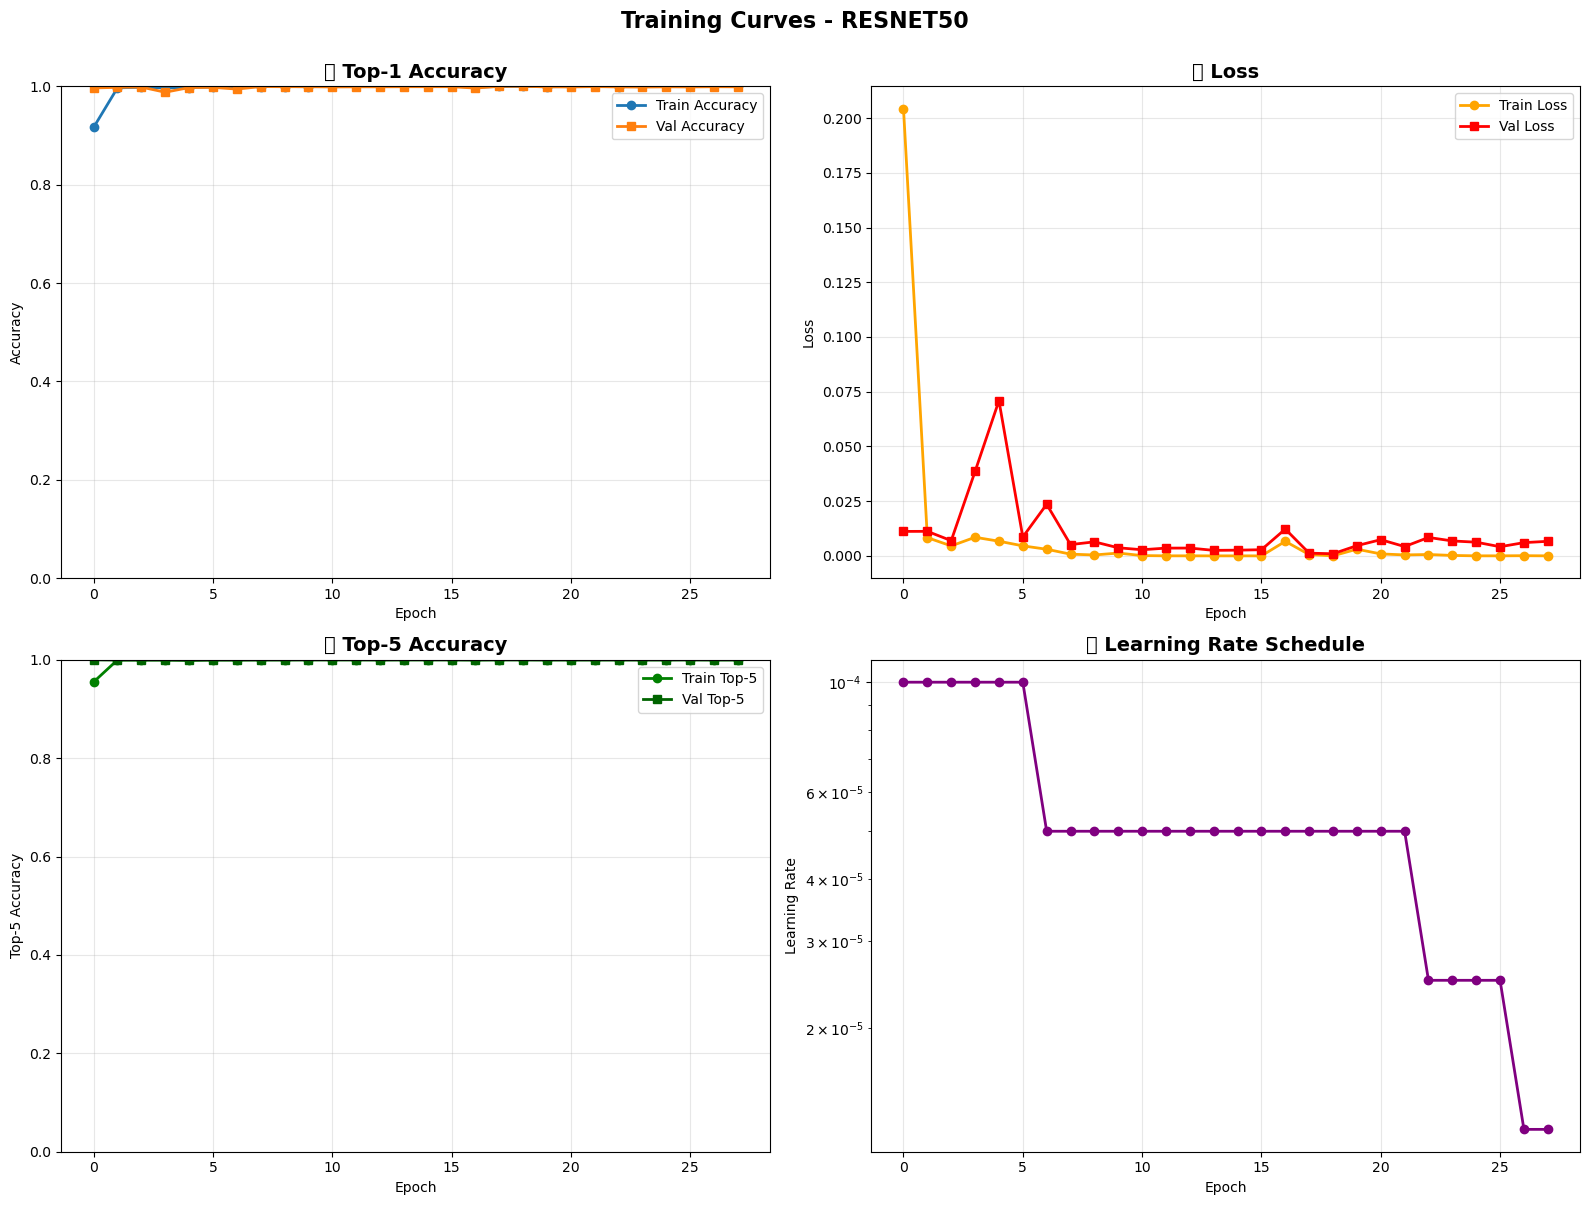

✅ Training curves displayed successfully!


In [17]:
# Create comprehensive training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top-1 Accuracy
axes[0, 0].plot(history["train_acc"], label="Train Accuracy", marker='o', linewidth=2)
axes[0, 0].plot(history["val_acc"], label="Val Accuracy", marker='s', linewidth=2)
axes[0, 0].set_title("📈 Top-1 Accuracy", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# 2. Loss
axes[0, 1].plot(history["train_loss"], label="Train Loss", marker='o', linewidth=2, color='orange')
axes[0, 1].plot(history["val_loss"], label="Val Loss", marker='s', linewidth=2, color='red')
axes[0, 1].set_title("📉 Loss", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Top-5 Accuracy
axes[1, 0].plot(history["train_top5_acc"], label="Train Top-5", marker='o', linewidth=2, color='green')
axes[1, 0].plot(history["val_top5_acc"], label="Val Top-5", marker='s', linewidth=2, color='darkgreen')
axes[1, 0].set_title("🎯 Top-5 Accuracy", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Top-5 Accuracy")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# 4. Learning Rate
axes[1, 1].plot(history["learning_rates"], marker='o', linewidth=2, color='purple')
axes[1, 1].set_title("📊 Learning Rate Schedule", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Learning Rate")
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f"Training Curves - {MODEL_ARCH.upper()}", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✅ Training curves displayed successfully!")


### Confusion Matrix

A confusion matrix provides a more detailed view of classification results.
It shows how many times the model correctly predicted each class versus how many times it confused it with another.

---

## 📊 POST-PROCESSING & EVALUATION

Comprehensive evaluation of the trained model on the test set.

🔍 Collecting model predictions on test set...
✅ Predictions collected successfully.

🎯 Overall Test Accuracy: 99.11%
🏆 Best performing class: Class 0 with 100.00% accuracy
⚠️  Worst performing class: Class 22 with 77.50% accuracy
🔄 Most confused pair: Class 8 ↔ Class 5 (20 misclassifications)
⚖️  Balanced Accuracy: 98.66%
✅ Average confidence (correct predictions): 99.87%
❌ Average confidence (incorrect predictions): 72.10%



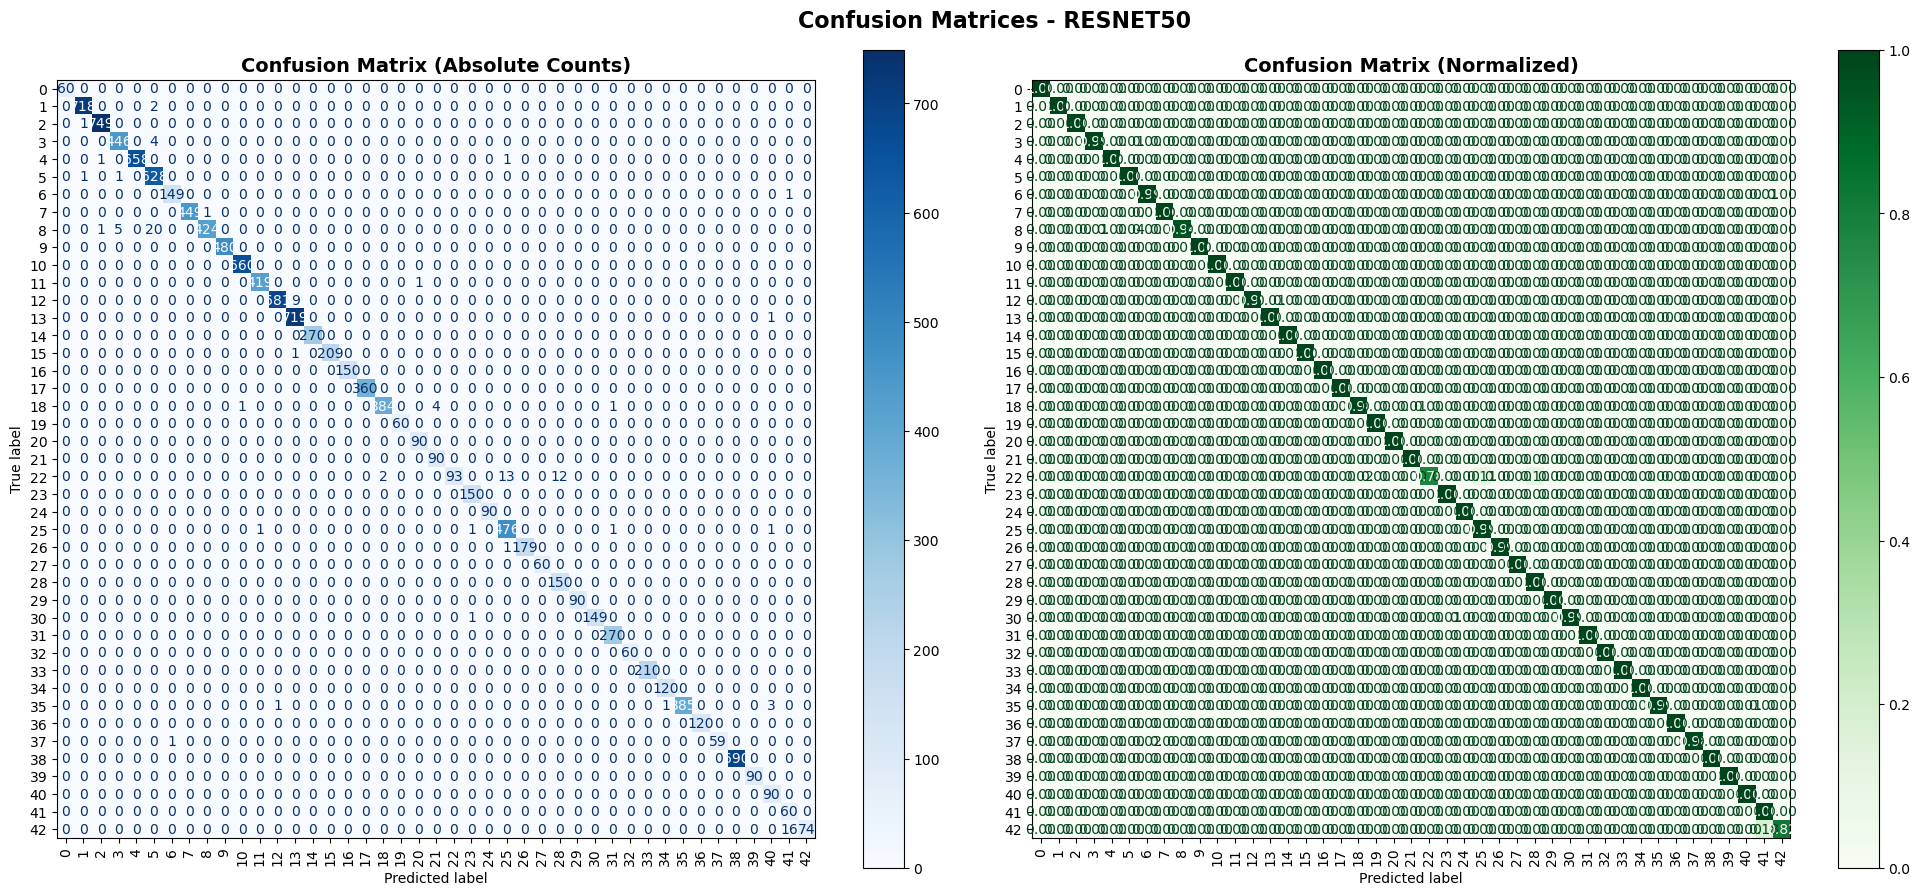


📊 Classification Report Summary:
              precision    recall  f1-score   support

     Class 0      1.000     1.000     1.000        60
     Class 1      0.997     0.997     0.997       720
     Class 2      0.997     0.999     0.998       750
     Class 3      0.987     0.991     0.989       450
     Class 4      1.000     0.997     0.998       660
     Class 5      0.960     0.997     0.978       630
     Class 6      0.993     0.993     0.993       150
     Class 7      1.000     0.998     0.999       450
     Class 8      0.998     0.942     0.969       450
     Class 9      1.000     1.000     1.000       480
    Class 10      0.998     1.000     0.999       660
    Class 11      0.998     0.998     0.998       420
    Class 12      0.999     0.987     0.993       690
    Class 13      0.986     0.999     0.992       720
    Class 14      1.000     1.000     1.000       270
    Class 15      1.000     0.995     0.998       210
    Class 16      1.000     1.000     1.000    

In [18]:
# 📊 Collect predictions on test set
print("🔍 Collecting model predictions on test set...")
all_preds = []
all_labels = []
all_probs = []  # Store probabilities for confidence analysis

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print("✅ Predictions collected successfully.")

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# 🧮 Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names from Meta.csv
meta_df = pd.read_csv(META_CSV)
class_names = meta_df['ClassId'].astype(str).tolist()

# ✅ Compute overall accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"\n{'='*60}")
print(f"🎯 Overall Test Accuracy: {accuracy * 100:.2f}%")
print(f"{'='*60}")

# ✅ Compute per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
best_class_idx = np.argmax(per_class_acc)
worst_class_idx = np.argmin(per_class_acc)
print(f"🏆 Best performing class: Class {best_class_idx} with {per_class_acc[best_class_idx]*100:.2f}% accuracy")
print(f"⚠️  Worst performing class: Class {worst_class_idx} with {per_class_acc[worst_class_idx]*100:.2f}% accuracy")

# ✅ Identify the most confused class pair
cm_copy = cm.copy().astype(float)
np.fill_diagonal(cm_copy, 0)
most_confused_idx = np.unravel_index(np.argmax(cm_copy), cm_copy.shape)
most_confused_value = int(cm_copy[most_confused_idx])
print(f"🔄 Most confused pair: Class {most_confused_idx[0]} ↔ Class {most_confused_idx[1]} ({most_confused_value} misclassifications)")

# 📊 Additional metrics
balanced_acc = balanced_accuracy_score(all_labels, all_preds)
print(f"⚖️  Balanced Accuracy: {balanced_acc * 100:.2f}%")

# Average confidence for correct and incorrect predictions
correct_mask = all_preds == all_labels
correct_confidences = [all_probs[i][all_preds[i]] for i in range(len(all_preds)) if correct_mask[i]]
incorrect_confidences = [all_probs[i][all_preds[i]] for i in range(len(all_preds)) if not correct_mask[i]]

avg_correct_conf = np.mean(correct_confidences) if len(correct_confidences) > 0 else 0
avg_incorrect_conf = np.mean(incorrect_confidences) if len(incorrect_confidences) > 0 else 0

print(f"✅ Average confidence (correct predictions): {avg_correct_conf * 100:.2f}%")
print(f"❌ Average confidence (incorrect predictions): {avg_incorrect_conf * 100:.2f}%")
print(f"{'='*60}\n")

# 📈 Plot confusion matrix (normalized and absolute)
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Absolute confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp1.plot(ax=axes[0], cmap='Blues', xticks_rotation=90, colorbar=True)
axes[0].set_title("Confusion Matrix (Absolute Counts)", fontsize=14, fontweight='bold')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=range(NUM_CLASSES))
disp2.plot(ax=axes[1], cmap='Greens', xticks_rotation=90, colorbar=True, values_format='.2f')
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=14, fontweight='bold')

plt.suptitle(f"Confusion Matrices - {MODEL_ARCH.upper()}", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 📄 Classification report
print("\n📊 Classification Report Summary:")
print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(NUM_CLASSES)], digits=3))

### Per-Class Detailed Metrics

Breakdown of precision, recall, and F1-score for each traffic sign class.

In [19]:
# 📋 Per-Class Detailed Metrics Table
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)

print("\n📊 Detailed Per-Class Metrics:")
print("="*90)
print(f"{'Class':<8} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("="*90)

# Sort by F1-score for better visibility
class_metrics = []
for i in range(NUM_CLASSES):
    class_metrics.append({
        'class': i,
        'accuracy': per_class_acc[i] * 100,
        'precision': precision[i] * 100,
        'recall': recall[i] * 100,
        'f1': f1[i] * 100,
        'support': int(support[i])
    })

# Display top 10 and bottom 10 classes
sorted_by_f1 = sorted(class_metrics, key=lambda x: x['f1'], reverse=True)

print("🏆 TOP 10 PERFORMING CLASSES:")
for metric in sorted_by_f1[:10]:
    print(f"{metric['class']:<8} {metric['accuracy']:>6.2f}%      {metric['precision']:>6.2f}%      "
          f"{metric['recall']:>6.2f}%      {metric['f1']:>6.2f}%      {metric['support']:<10}")

print("\n⚠️  BOTTOM 10 PERFORMING CLASSES:")
for metric in sorted_by_f1[-10:]:
    print(f"{metric['class']:<8} {metric['accuracy']:>6.2f}%      {metric['precision']:>6.2f}%      "
          f"{metric['recall']:>6.2f}%      {metric['f1']:>6.2f}%      {metric['support']:<10}")

print("="*90)

# Compute macro and weighted averages
macro_precision = np.mean(precision) * 100
macro_recall = np.mean(recall) * 100
macro_f1 = np.mean(f1) * 100

weighted_precision = np.average(precision, weights=support) * 100
weighted_recall = np.average(recall, weights=support) * 100
weighted_f1 = np.average(f1, weights=support) * 100

print(f"\n📊 AGGREGATE METRICS:")
print(f"  Macro Avg:    Precision={macro_precision:.2f}%  Recall={macro_recall:.2f}%  F1={macro_f1:.2f}%")
print(f"  Weighted Avg: Precision={weighted_precision:.2f}%  Recall={weighted_recall:.2f}%  F1={weighted_f1:.2f}%")


📊 Detailed Per-Class Metrics:
Class    Accuracy     Precision    Recall       F1-Score     Support   
🏆 TOP 10 PERFORMING CLASSES:
0        100.00%      100.00%      100.00%      100.00%      60        
9        100.00%      100.00%      100.00%      100.00%      480       
14       100.00%      100.00%      100.00%      100.00%      270       
16       100.00%      100.00%      100.00%      100.00%      150       
17       100.00%      100.00%      100.00%      100.00%      360       
19       100.00%      100.00%      100.00%      100.00%      60        
24       100.00%      100.00%      100.00%      100.00%      90        
27       100.00%      100.00%      100.00%      100.00%      60        
29       100.00%      100.00%      100.00%      100.00%      90        
32       100.00%      100.00%      100.00%      100.00%      60        

⚠️  BOTTOM 10 PERFORMING CLASSES:
3         99.11%       98.67%       99.11%       98.89%      450       
25        99.17%       96.95%       99.17

### Performance Visualizations

Additional charts for comprehensive model analysis.

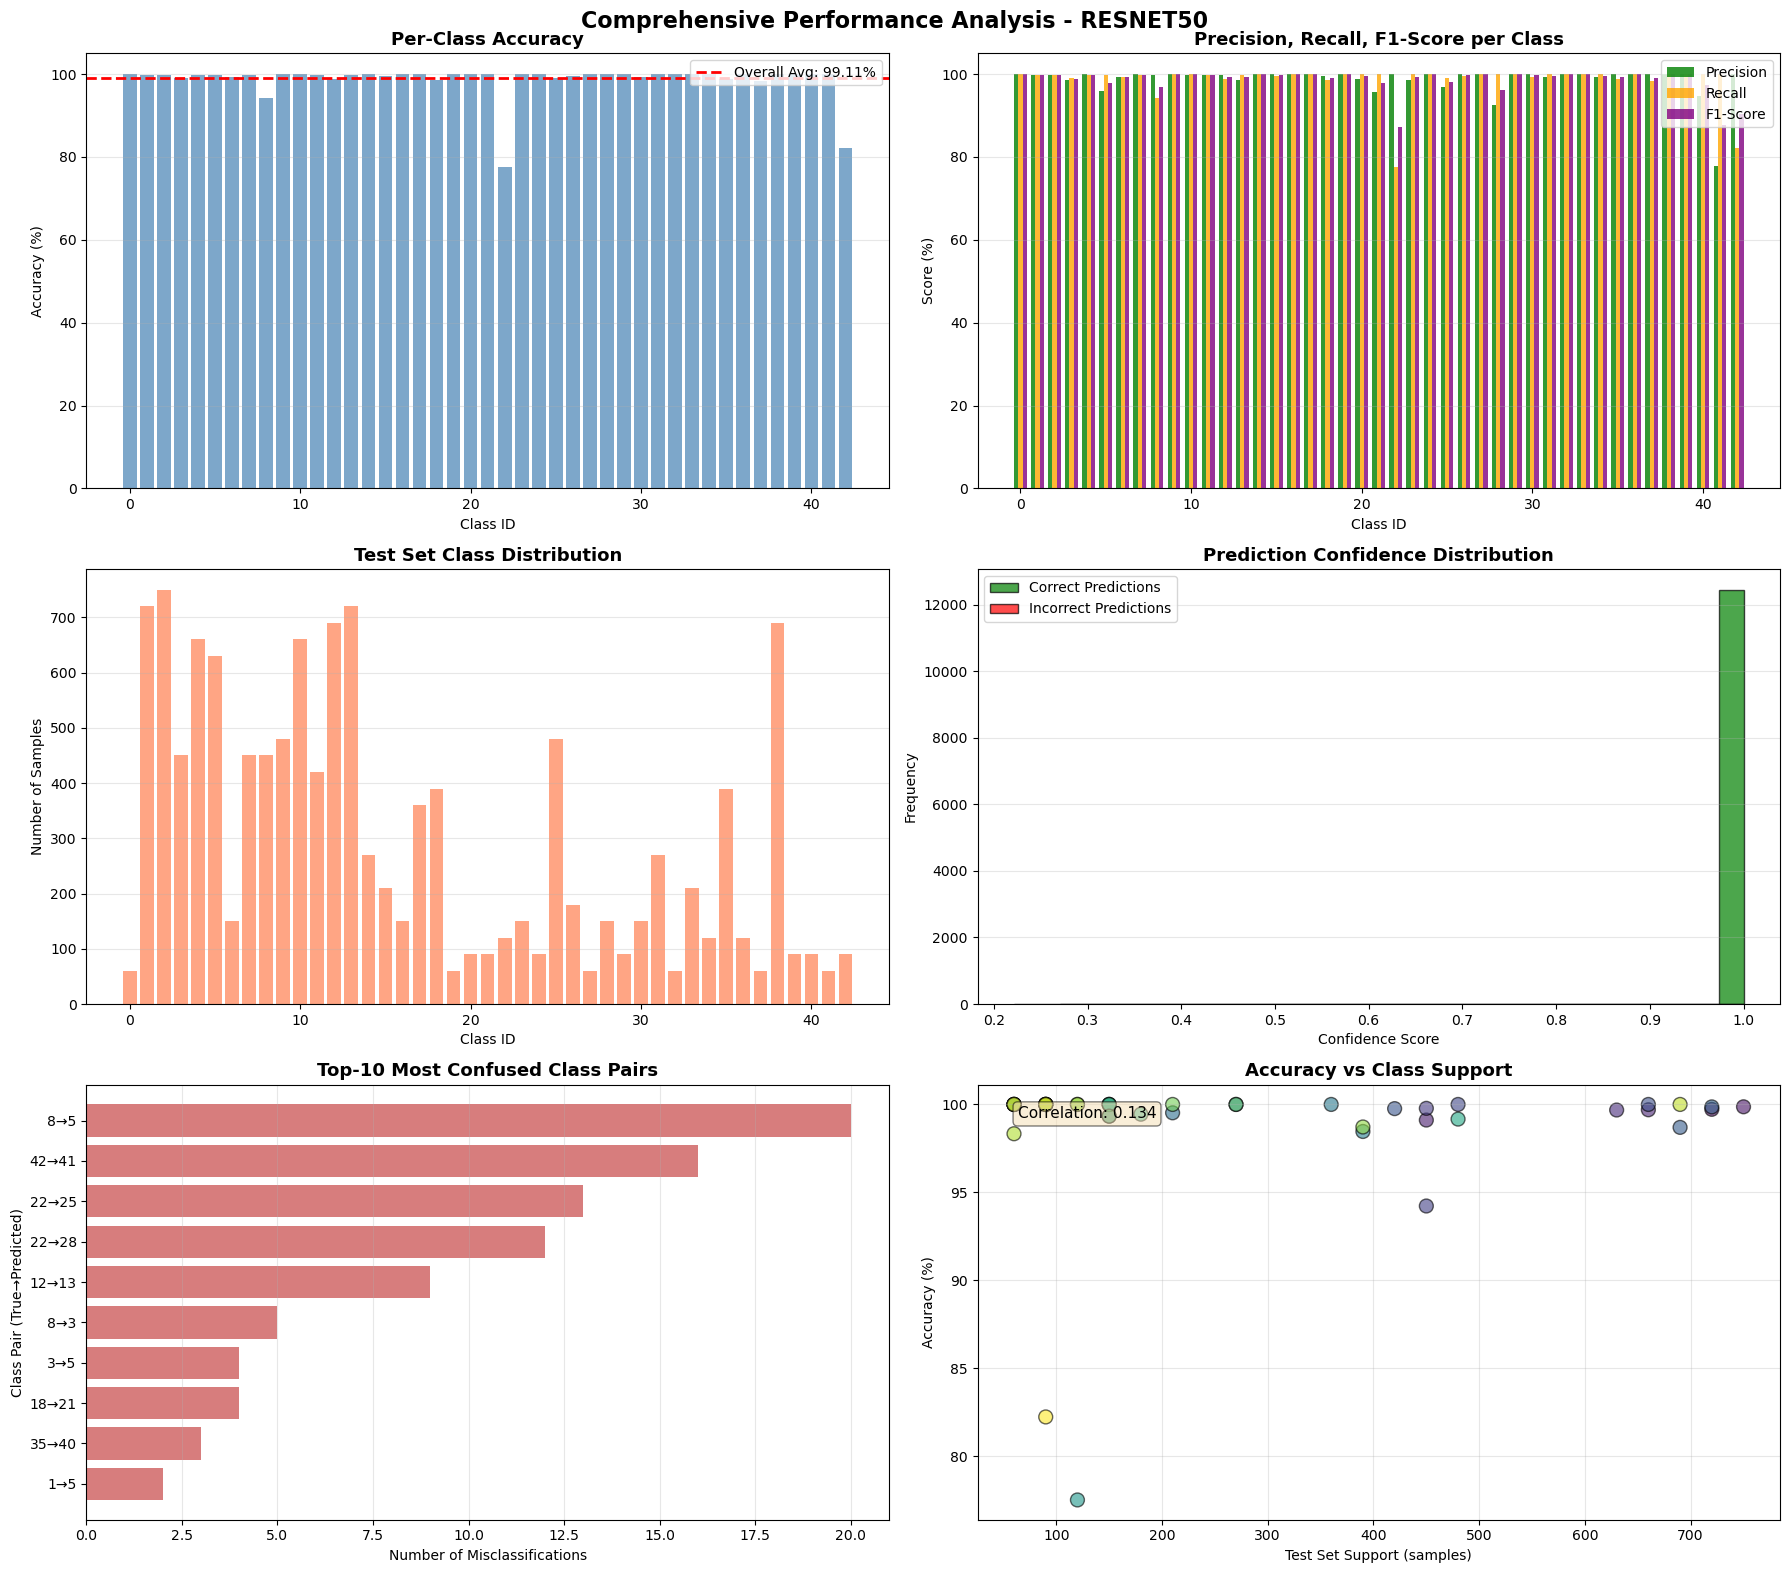

✅ Performance visualizations generated successfully!


In [20]:
# 📊 Performance Visualization - 6 Panel Analysis
fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# 1. Per-Class Accuracy Bar Chart
axes[0, 0].bar(range(NUM_CLASSES), per_class_acc * 100, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=accuracy * 100, color='red', linestyle='--', linewidth=2, label=f'Overall Avg: {accuracy*100:.2f}%')
axes[0, 0].set_xlabel('Class ID')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_title('Per-Class Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Precision, Recall, F1-Score Comparison
x_pos = np.arange(NUM_CLASSES)
width = 0.25
axes[0, 1].bar(x_pos - width, precision * 100, width, label='Precision', alpha=0.8, color='green')
axes[0, 1].bar(x_pos, recall * 100, width, label='Recall', alpha=0.8, color='orange')
axes[0, 1].bar(x_pos + width, f1 * 100, width, label='F1-Score', alpha=0.8, color='purple')
axes[0, 1].set_xlabel('Class ID')
axes[0, 1].set_ylabel('Score (%)')
axes[0, 1].set_title('Precision, Recall, F1-Score per Class', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Class Support Distribution
axes[1, 0].bar(range(NUM_CLASSES), support, color='coral', alpha=0.7)
axes[1, 0].set_xlabel('Class ID')
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].set_title('Test Set Class Distribution', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Confidence Distribution (Correct vs Incorrect)
axes[1, 1].hist(correct_confidences, bins=30, alpha=0.7, label='Correct Predictions', color='green', edgecolor='black')
axes[1, 1].hist(incorrect_confidences, bins=30, alpha=0.7, label='Incorrect Predictions', color='red', edgecolor='black')
axes[1, 1].set_xlabel('Confidence Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Prediction Confidence Distribution', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 5. Top-10 Most Confused Class Pairs
cm_off_diagonal = cm.copy().astype(float)
np.fill_diagonal(cm_off_diagonal, 0)
confused_pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm_off_diagonal[i, j] > 0:
            confused_pairs.append((i, j, int(cm_off_diagonal[i, j])))

confused_pairs_sorted = sorted(confused_pairs, key=lambda x: x[2], reverse=True)[:10]
pair_labels = [f"{p[0]}→{p[1]}" for p in confused_pairs_sorted]
pair_counts = [p[2] for p in confused_pairs_sorted]

axes[2, 0].barh(pair_labels, pair_counts, color='indianred', alpha=0.8)
axes[2, 0].set_xlabel('Number of Misclassifications')
axes[2, 0].set_ylabel('Class Pair (True→Predicted)')
axes[2, 0].set_title('Top-10 Most Confused Class Pairs', fontsize=13, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3, axis='x')
axes[2, 0].invert_yaxis()

# 6. Accuracy vs Support Scatter Plot
axes[2, 1].scatter(support, per_class_acc * 100, s=100, alpha=0.6, c=range(NUM_CLASSES), cmap='viridis', edgecolors='black')
axes[2, 1].set_xlabel('Test Set Support (samples)')
axes[2, 1].set_ylabel('Accuracy (%)')
axes[2, 1].set_title('Accuracy vs Class Support', fontsize=13, fontweight='bold')
axes[2, 1].grid(True, alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(support, per_class_acc)[0, 1]
axes[2, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[2, 1].transAxes, fontsize=11, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Comprehensive Performance Analysis - {MODEL_ARCH.upper()}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Performance visualizations generated successfully!")

### Error Analysis

Analyzing misclassification patterns to understand model weaknesses.

In [21]:
# 🔍 Error Analysis
print("🔍 Analyzing misclassification patterns...\n")

# Find indices of misclassified samples
misclassified_indices = np.where(all_preds != all_labels)[0]
num_errors = len(misclassified_indices)

print(f"❌ Total misclassifications: {num_errors} out of {len(all_labels)} ({num_errors/len(all_labels)*100:.2f}%)")

# Analyze error distribution by true class
error_by_class = {}
for idx in misclassified_indices:
    true_class = all_labels[idx]
    pred_class = all_preds[idx]
    
    if true_class not in error_by_class:
        error_by_class[true_class] = []
    error_by_class[true_class].append(pred_class)

# Classes with most errors
class_error_counts = {cls: len(errors) for cls, errors in error_by_class.items()}
sorted_error_classes = sorted(class_error_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\n🔴 Top-10 Classes with Most Errors:")
print("="*60)
print(f"{'Class':<10} {'Errors':<12} {'Error Rate':<15}")
print("="*60)
for cls, error_count in sorted_error_classes[:10]:
    total_samples = support[cls]
    error_rate = (error_count / total_samples) * 100 if total_samples > 0 else 0
    print(f"{cls:<10} {error_count:<12} {error_rate:>6.2f}%")
print("="*60)

# Confidence analysis for errors
print(f"\n📊 Confidence Analysis for Misclassifications:")
if len(incorrect_confidences) > 0:
    conf_quartiles = np.percentile(incorrect_confidences, [25, 50, 75])
    print(f"  25th percentile: {conf_quartiles[0]*100:.2f}%")
    print(f"  50th percentile (median): {conf_quartiles[1]*100:.2f}%")
    print(f"  75th percentile: {conf_quartiles[2]*100:.2f}%")
    
    high_confidence_errors = sum(1 for c in incorrect_confidences if c > 0.8)
    print(f"  High-confidence errors (>80%): {high_confidence_errors} ({high_confidence_errors/len(incorrect_confidences)*100:.1f}%)")

# Error patterns - which classes are commonly mistaken for each other
print(f"\n🔄 Most Common Misclassification Patterns:")
print("="*70)
print(f"{'True Class':<15} {'Predicted As':<15} {'Count':<12} {'% of Class':<15}")
print("="*70)
for true_cls, pred_list in sorted(error_by_class.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
    pred_counts = {}
    for pred in pred_list:
        pred_counts[pred] = pred_counts.get(pred, 0) + 1
    
    most_common_pred = max(pred_counts.items(), key=lambda x: x[1])
    pct_of_class = (most_common_pred[1] / support[true_cls]) * 100
    print(f"{true_cls:<15} {most_common_pred[0]:<15} {most_common_pred[1]:<12} {pct_of_class:>6.2f}%")
print("="*70)

print("\n✅ Error analysis complete!")

🔍 Analyzing misclassification patterns...

❌ Total misclassifications: 112 out of 12630 (0.89%)

🔴 Top-10 Classes with Most Errors:
Class      Errors       Error Rate     
22         27            22.50%
8          26             5.78%
42         16            17.78%
12         9              1.30%
18         6              1.54%
35         5              1.28%
25         4              0.83%
3          4              0.89%
1          2              0.28%
4          2              0.30%

📊 Confidence Analysis for Misclassifications:
  25th percentile: 53.43%
  50th percentile (median): 76.03%
  75th percentile: 93.49%
  High-confidence errors (>80%): 52 (46.4%)

🔄 Most Common Misclassification Patterns:
True Class      Predicted As    Count        % of Class     
22              25              13            10.83%
8               5               20             4.44%
42              41              16            17.78%
12              13              9              1.30%
18            

### Final Summary Report

Comprehensive summary of model performance and key findings.

In [22]:
# 📋 Final Summary Report
print("\n" + "="*80)
print(" "*25 + "🎯 MODEL EVALUATION SUMMARY")
print("="*80)

print(f"\n📦 Model Architecture: {MODEL_ARCH.upper()}")
print(f"📊 Dataset: GTSRB (German Traffic Sign Recognition Benchmark)")
print(f"🔢 Number of Classes: {NUM_CLASSES}")
print(f"🧪 Test Set Size: {len(all_labels)} images")

print(f"\n{'─'*80}")
print("📈 OVERALL PERFORMANCE METRICS:")
print(f"{'─'*80}")
print(f"  Overall Accuracy:        {accuracy * 100:>6.2f}%")
print(f"  Balanced Accuracy:       {balanced_acc * 100:>6.2f}%")
print(f"  Macro Precision:         {macro_precision:>6.2f}%")
print(f"  Macro Recall:            {macro_recall:>6.2f}%")
print(f"  Macro F1-Score:          {macro_f1:>6.2f}%")
print(f"  Weighted Precision:      {weighted_precision:>6.2f}%")
print(f"  Weighted Recall:         {weighted_recall:>6.2f}%")
print(f"  Weighted F1-Score:       {weighted_f1:>6.2f}%")

print(f"\n{'─'*80}")
print("✅ BEST PERFORMING CLASSES (Top-3):")
print(f"{'─'*80}")
for i, metric in enumerate(sorted_by_f1[:3], 1):
    print(f"  {i}. Class {metric['class']:2d}: F1={metric['f1']:6.2f}%, "
          f"Accuracy={metric['accuracy']:6.2f}%, Support={metric['support']}")

print(f"\n{'─'*80}")
print("⚠️  WORST PERFORMING CLASSES (Bottom-3):")
print(f"{'─'*80}")
for i, metric in enumerate(sorted_by_f1[-3:], 1):
    print(f"  {i}. Class {metric['class']:2d}: F1={metric['f1']:6.2f}%, "
          f"Accuracy={metric['accuracy']:6.2f}%, Support={metric['support']}")

print(f"\n{'─'*80}")
print("🔄 CONFUSION INSIGHTS:")
print(f"{'─'*80}")
print(f"  Most confused pair: Class {most_confused_idx[0]} → Class {most_confused_idx[1]} "
      f"({most_confused_value} misclassifications)")
print(f"  Total misclassifications: {num_errors}")
print(f"  Error rate: {num_errors/len(all_labels)*100:.2f}%")

print(f"\n{'─'*80}")
print("🎲 CONFIDENCE STATISTICS:")
print(f"{'─'*80}")
print(f"  Avg confidence (correct):   {avg_correct_conf * 100:>6.2f}%")
print(f"  Avg confidence (incorrect): {avg_incorrect_conf * 100:>6.2f}%")
print(f"  Confidence gap:             {(avg_correct_conf - avg_incorrect_conf) * 100:>6.2f}%")

print(f"\n{'─'*80}")
print("💾 MODEL ARTIFACTS:")
print(f"{'─'*80}")
print(f"  Saved model: GTSRB_{MODEL_ARCH}_E{{epoch}}_VAL{{accuracy}}.pth")
print(f"  Training history: Stored in 'history' dictionary")
print(f"  Metrics tracked: Top-1 Acc, Top-5 Acc, Loss, Learning Rate")

print(f"\n{'─'*80}")
print("🚀 TRAINING CONFIGURATION:")
print(f"{'─'*80}")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"  Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {MAX_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"  Dropout rate: {DROPOUT_RATE}")
print(f"  Gradient clipping: max_norm={MAX_GRAD_NORM}")
print(f"  Validation split: {VALIDATION_SPLIT*100:.0f}%")

print(f"\n{'='*80}")
print(" "*20 + "✅ EVALUATION COMPLETE!")
print("="*80 + "\n")


                         🎯 MODEL EVALUATION SUMMARY

📦 Model Architecture: RESNET50
📊 Dataset: GTSRB (German Traffic Sign Recognition Benchmark)
🔢 Number of Classes: 43
🧪 Test Set Size: 12630 images

────────────────────────────────────────────────────────────────────────────────
📈 OVERALL PERFORMANCE METRICS:
────────────────────────────────────────────────────────────────────────────────
  Overall Accuracy:         99.11%
  Balanced Accuracy:        98.66%
  Macro Precision:          98.72%
  Macro Recall:             98.66%
  Macro F1-Score:           98.59%
  Weighted Precision:       99.16%
  Weighted Recall:          99.11%
  Weighted F1-Score:        99.10%

────────────────────────────────────────────────────────────────────────────────
✅ BEST PERFORMING CLASSES (Top-3):
────────────────────────────────────────────────────────────────────────────────
  1. Class  0: F1=100.00%, Accuracy=100.00%, Support=60
  2. Class  9: F1=100.00%, Accuracy=100.00%, Support=480
  3. Class 14: 